In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torchvision

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [40]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [154]:
# Define data loading step

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64)

In [155]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [156]:
print(len(train_loader.dataset))

60000


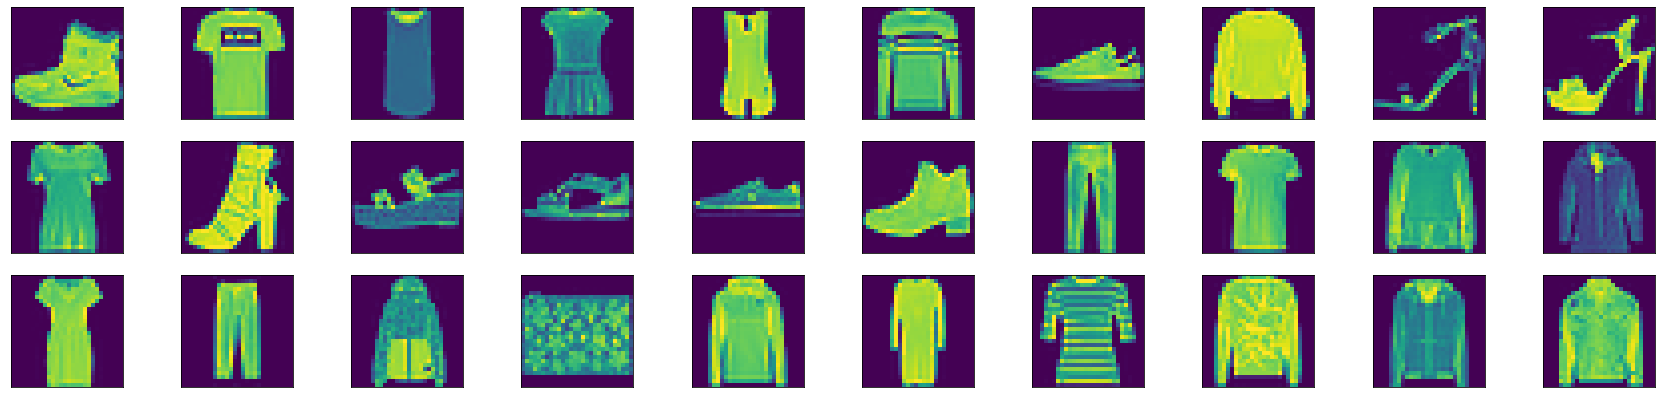

In [157]:
# Let's see if the train loader is working and sending us iterable images :) 
# Also note that we converted images to tensor above with ToTensor(). Now we need to convert back to numpy to plot them

# obtain one batch of training images which means 32 images
dataiter = iter(train_loader)
img, _ = dataiter.next() # _ for labels, Dataloader sends labels automatically as defined in Dataloader class.
#However we don't need labels neither we assigned one :p so we put _ 
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 7))
plot_size=30 # gonna plot 30 images only
for idx in np.arange(plot_size):
    ax = fig.add_subplot(3, plot_size//3, idx+1, xticks=[], yticks=[])
    npimg = img[idx].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Discriminator

In [158]:
'''
The inputs to the discriminator are 28x28x1 tensor images
The output would be a single value that will indicate whether a given image is real or fake
'''
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [159]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(1, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*8, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*8)
        
        x = self.fc(x)
        
        
        return x

## Generator

In [229]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [244]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim * 4 * 7 * 7)
        # complete init function
        
        self.de_conv1 = deconv(conv_dim*4, conv_dim*2, batch_norm = True)
        self.de_conv2 = deconv(conv_dim*2, 1, batch_norm = True)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 28x28x1 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 7, 7)
        
        x = F.relu(self.de_conv1(x))
        x = self.de_conv2(x)
        x = F.tanh(x)
        
        
        return x

In [245]:
#Initializing the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.

def weights_init_normal(m):
    """
    :param m: A module or layer in a network    
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [246]:
# model hyperparameters
d_conv_dim = 64
g_conv_dim = 64
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")

done


In [247]:
# let's look at our discriminator model
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [248]:
# let's look at our generator model
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


In [249]:
x = torch.randn(100)
print(generator.forward(x).shape)

torch.Size([1, 1, 28, 28])


In [250]:
use_gpu = torch.cuda.is_available()

In [251]:
lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2)) # for generator

In [252]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    if use_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if use_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [253]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)      # Calculates log(D(x))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)  # The Generator wishies to minimize the real_loss for it's fake output
                                        # to trick the Discriminator
        
            g_loss.backward()
            generator_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [259]:
n_epochs = 10
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

Epoch [    1/   10] | d_loss: 0.3712 | g_loss: 2.4774
Epoch [    1/   10] | d_loss: 0.3775 | g_loss: 2.5547
Epoch [    1/   10] | d_loss: 0.3884 | g_loss: 2.5560
Epoch [    1/   10] | d_loss: 0.3426 | g_loss: 2.6932
Epoch [    1/   10] | d_loss: 0.2074 | g_loss: 2.5671
Epoch [    1/   10] | d_loss: 0.2820 | g_loss: 2.8213
Epoch [    1/   10] | d_loss: 0.2480 | g_loss: 2.7017
Epoch [    1/   10] | d_loss: 0.2021 | g_loss: 2.9780
Epoch [    1/   10] | d_loss: 0.1760 | g_loss: 2.8039
Epoch [    1/   10] | d_loss: 0.2114 | g_loss: 2.8619
Epoch [    1/   10] | d_loss: 0.2791 | g_loss: 2.8923
Epoch [    1/   10] | d_loss: 0.2908 | g_loss: 2.8228
Epoch [    1/   10] | d_loss: 0.3101 | g_loss: 2.8363
Epoch [    1/   10] | d_loss: 0.1753 | g_loss: 2.8933
Epoch [    1/   10] | d_loss: 0.1902 | g_loss: 2.9331
Epoch [    1/   10] | d_loss: 0.2179 | g_loss: 2.9447
Epoch [    1/   10] | d_loss: 0.1488 | g_loss: 3.1003
Epoch [    1/   10] | d_loss: 0.1604 | g_loss: 3.2256
Epoch [    1/   10] | d_loss

Epoch [    5/   10] | d_loss: 0.0994 | g_loss: 4.4132
Epoch [    5/   10] | d_loss: 0.0575 | g_loss: 5.1861
Epoch [    5/   10] | d_loss: 0.0915 | g_loss: 4.0713
Epoch [    5/   10] | d_loss: 0.1006 | g_loss: 4.5152
Epoch [    5/   10] | d_loss: 0.0612 | g_loss: 5.3857
Epoch [    5/   10] | d_loss: 0.0262 | g_loss: 6.1358
Epoch [    5/   10] | d_loss: 0.0317 | g_loss: 3.3762
Epoch [    5/   10] | d_loss: 0.0222 | g_loss: 4.1264
Epoch [    5/   10] | d_loss: 0.0311 | g_loss: 4.9311
Epoch [    5/   10] | d_loss: 0.0331 | g_loss: 5.5634
Epoch [    5/   10] | d_loss: 0.0283 | g_loss: 4.0675
Epoch [    5/   10] | d_loss: 0.0468 | g_loss: 4.2112
Epoch [    5/   10] | d_loss: 0.0445 | g_loss: 4.6050
Epoch [    5/   10] | d_loss: 0.0329 | g_loss: 4.5418
Epoch [    5/   10] | d_loss: 0.0389 | g_loss: 5.3014
Epoch [    5/   10] | d_loss: 0.0655 | g_loss: 4.1759
Epoch [    5/   10] | d_loss: 0.0544 | g_loss: 4.9439
Epoch [    5/   10] | d_loss: 0.0416 | g_loss: 3.8766
Epoch [    5/   10] | d_loss

Epoch [    9/   10] | d_loss: 0.0285 | g_loss: 5.5303
Epoch [    9/   10] | d_loss: 0.0552 | g_loss: 5.9064
Epoch [    9/   10] | d_loss: 0.0653 | g_loss: 6.2652
Epoch [    9/   10] | d_loss: 0.0694 | g_loss: 5.7252
Epoch [    9/   10] | d_loss: 0.0341 | g_loss: 5.5290
Epoch [    9/   10] | d_loss: 0.0560 | g_loss: 6.6031
Epoch [    9/   10] | d_loss: 0.0245 | g_loss: 6.6826
Epoch [    9/   10] | d_loss: 0.0089 | g_loss: 4.8456
Epoch [    9/   10] | d_loss: 0.3271 | g_loss: 5.1684
Epoch [    9/   10] | d_loss: 0.0137 | g_loss: 6.6340
Epoch [    9/   10] | d_loss: 0.0083 | g_loss: 6.8453
Epoch [    9/   10] | d_loss: 0.0277 | g_loss: 4.0362
Epoch [    9/   10] | d_loss: 0.0330 | g_loss: 4.9544
Epoch [    9/   10] | d_loss: 0.0261 | g_loss: 5.6163
Epoch [    9/   10] | d_loss: 0.0107 | g_loss: 4.0825
Epoch [    9/   10] | d_loss: 0.0533 | g_loss: 4.1826
Epoch [    9/   10] | d_loss: 0.0243 | g_loss: 6.8027
Epoch [    9/   10] | d_loss: 0.0222 | g_loss: 5.8291
Epoch [    9/   10] | d_loss

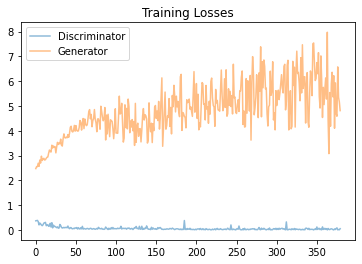

In [260]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [261]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28,1)))

In [262]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

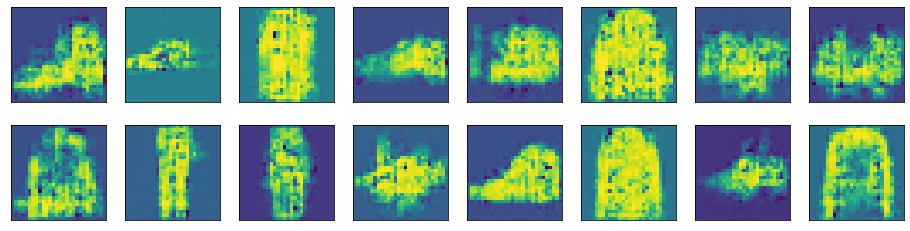

In [263]:
_ = view_samples(-1, samples)